<a href="https://colab.research.google.com/github/sonovman/GNN-from-scratch/blob/main/1_1_Distill__Graph_Convolution_%EC%8B%AC%ED%99%94_%ED%95%99%EC%8A%B5%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Convolutions on Graphs**

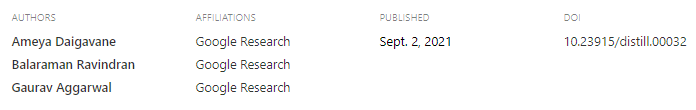

https://distill.pub/2021/understanding-gnns/

원문 번역 용어를 통일하기 위하여 아래와 같이 정한다.

- feature : 특성 (회귀의 입력변수 x )
- label : 라벨(예측항목 또는 회귀문제에서 y 변수)
- model : 특성과 라벨의 관계를 정의한 수식
- learning : 모델을 만들거나 배우는 것, 즉 특성과 라벨의 관계를 점차 배워나가는 것
- 추론 : 학습된 모델을 사용하여 라벨을 예측하는 것


# **0.Introduction**

전통적인 신경망(neural networks)은 고정된 크기 및/또는 규칙적으로 구조화된 입력(예: 문장, 이미지 및 비디오)에서 작동하는 데 사용되었다. 

이것은 그래프 구조의 데이터를 우아하게 처리할 수 없다.

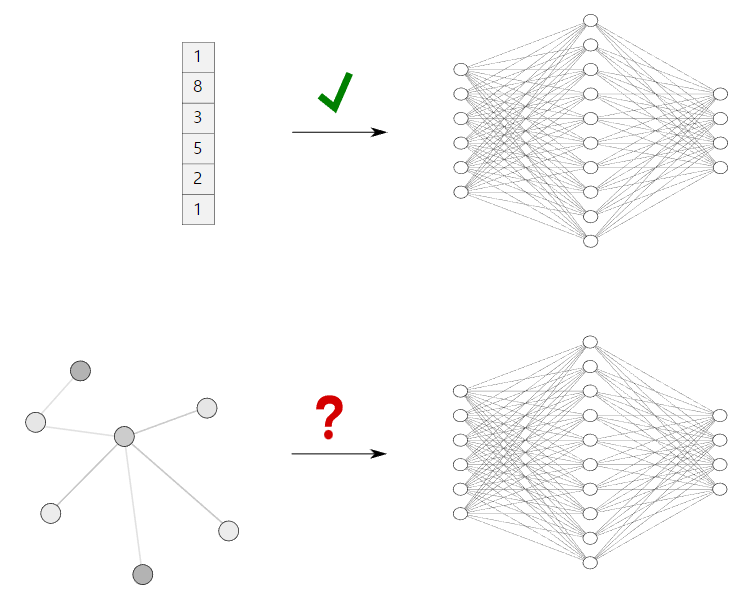

# **1.The Challenges(과제/문제) of Computation on Graphs**

##**[일관된 구조의 부족]**

그래프는 매우 유연한 수학적 모델이다. 이는 인스턴스 간에 구조가 일관되지 않는다는 것을 의미

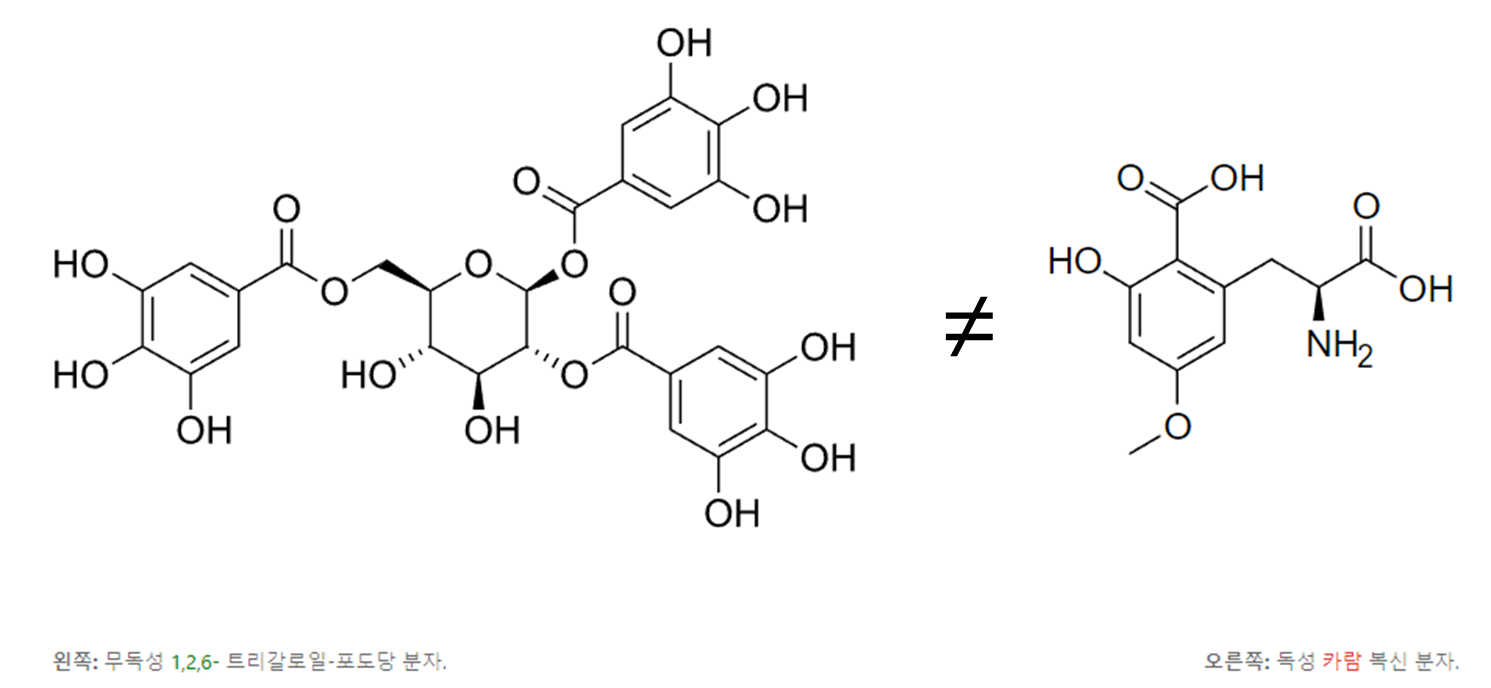

- Molecules may have different numbers of atoms.
- The atoms in a molecule may be of different types.
- Each of these atoms may have different number of connections.
- These connections can have different strengths.

##**[Node-Order Equivariance 노드 순서 등분산]**

모든 픽셀의 절대위치와 순서가 고정된 이미지데이터와 달리, 그래프는 고정된 위치의 순서에 의존하지 않는다. 즉 알고리즘이 노드 순서 등변량이기를 원한다. 

즉, 그래프 노드의 순서에 의존하지 않아야 한다. 어떤 식으로든 노드를 치환하면 알고리즘에 의해 계산된 노드의 결과 표현도 같은 방식으로 치환되어야 한다.  

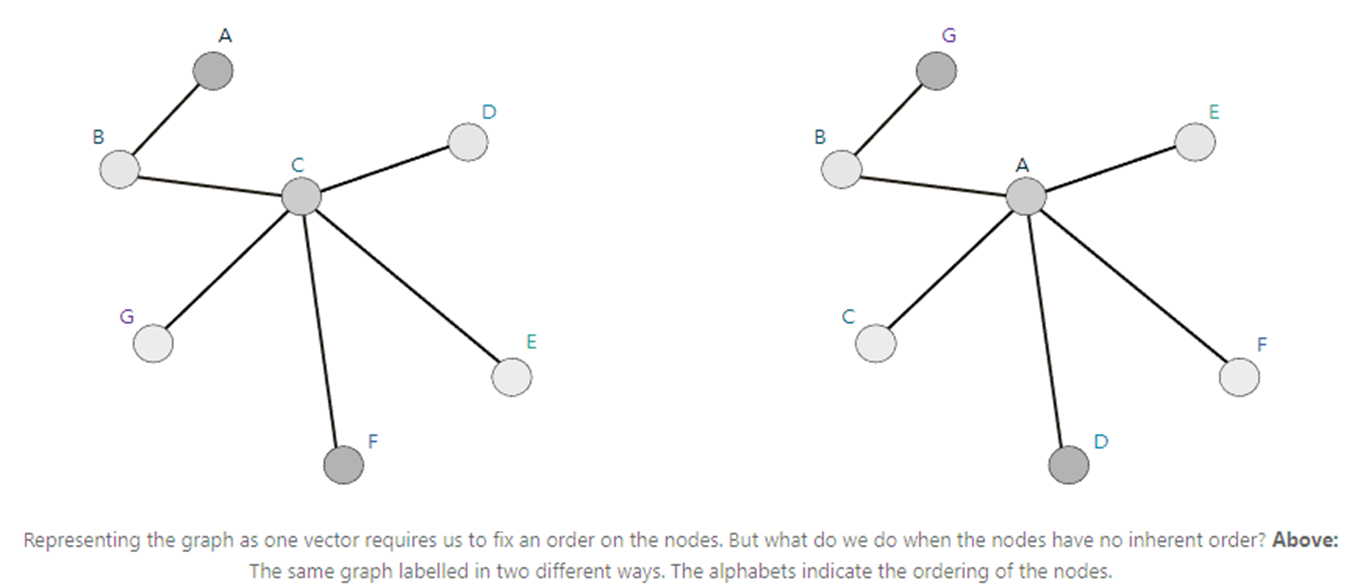

##**[Scalability 확장성]**

그래프는 정말 커질 수 있다! 10억 명이 넘는 사용자를 보유한 Facebook 및 Twitter와 같은 소셜 네트워크를 생각해 보라. 이렇게 큰 데이터를 조작하는 것은 쉽지 않다.

운 좋게도 대부분의 자연적으로 발생하는 그래프는 '희소'(sparse)하다. 정점 수에서 선형의 가장자리 수를 갖는 경향이 있다. 

이를 통해 그래프 내의 노드 표현을 효율적으로 계산하는 영리한 방법을 사용할 수 있다. 또한 여기에서 살펴보는 메서드는 작동하는 그래프의 크기에 비해 매개변수가 훨씬 적다.

# **2.Problem Setting and Notation (응용분야 및 표기법)**

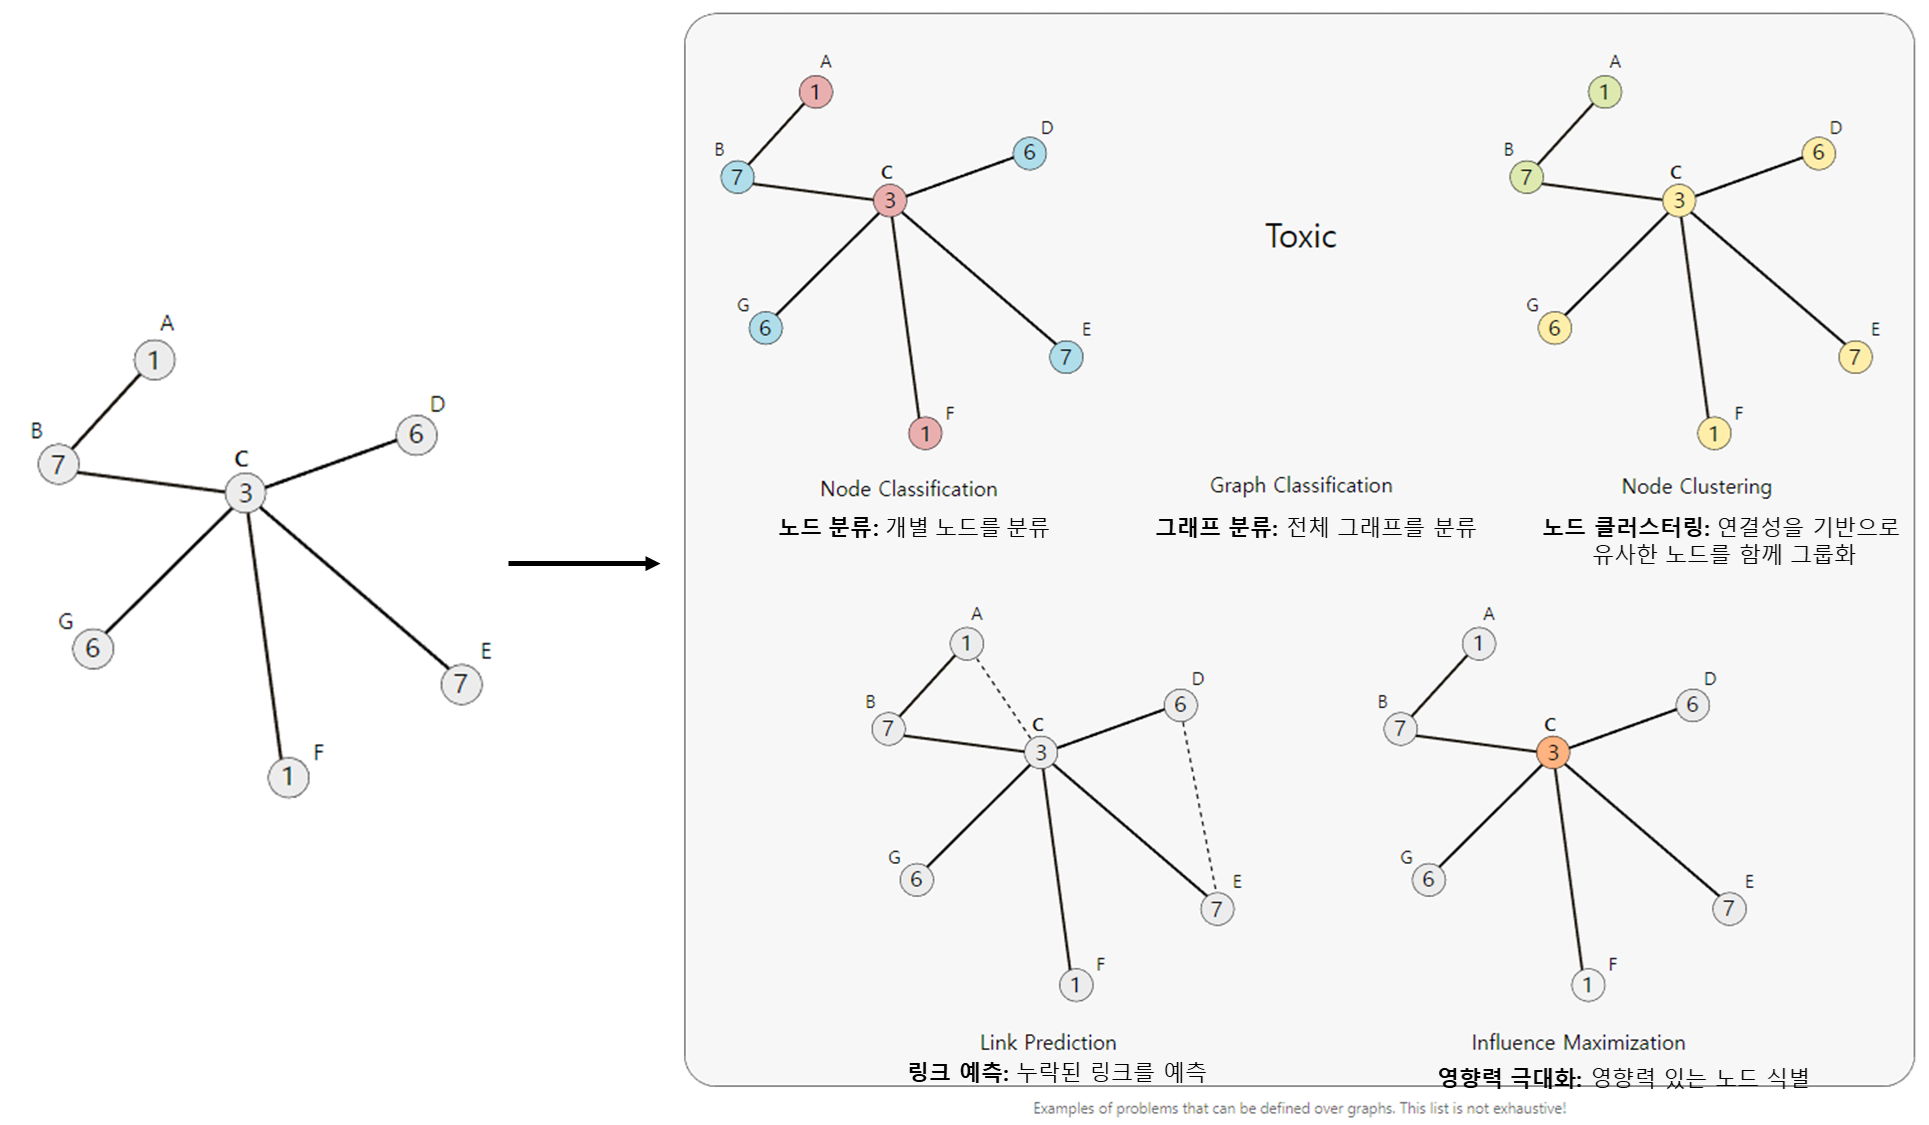

이러한 많은 문제를 해결하는 일반적인 선구자는 **노드 표현 학습(node representation learning)** 이다. 즉, 개별 노드를 고정 크기의 실제 값 벡터('**표현(representations)**' 또는 '**임베딩(embeddings)**'이라고 함)에 매핑하는 학습이다.

GNN 매개변수 학습편에서, 학습된 임베딩이 이러한 작업에 어떻게 사용될 수 있는지 알아볼 것이다.

다른 GNN 변형은 이러한 표현이 계산되는 방식에 의해 구별된다. 그러나 일반적으로 GNN은 반복 프로세스에서 노드 표현(임베딩)을 계산한다. 

우리는 $k^{th}$  반복 뒤에 노드 $v$의 표현(임베딩)의 표기법을 $h^{(k)}_v$로 사용할 것이다(히든 픽쳐 벡터). 각 반복은 표준 신경망의 '층(layer)'과 동일하다고 생각할 수 있다.

우리는 그래프 $G$를 노드를 잇는 엣지 집합 $E$를 가지고 노드 집합 $V$으로 정의할 것이다 노드는 입력의 일부로 개별 feature 을 가질 수 있다. 노드 $v ∈ V$에 대한 개별 특성(feature)를 $x_v$로 표기할 것이다.

예를 들어, 컬러 이미지의 픽셀에 대한 '노드 특성(node feature)'은 해당 픽셀의 RGB(빨간색, 녹색 및 파란색 채널) 값입니다.

설명의 편의를 위해 G는 무방향성 그래프이고 모든 노드는 동일한 유형으로 가정하겠다. 

때때로 행렬 $M$으로 그래프 속성을 나타내기도 할 것이다. 이때 각 행(row) $M_v$은 특정 정점 $v$에 해당하는 속성을 나타낸다.

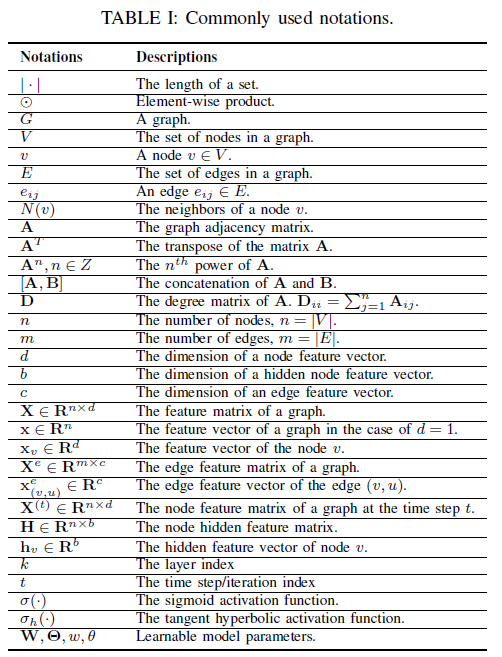

# **3.Extending Convolutions to Graphs (컨벌루션을 그래프로 확장)**



Convolutional Neural Networks는 이미지에서 특성을 추출하는 데 꽤 강력하다. 그러나 이미지 자체는 개별 픽셀이 노드이고 각 픽셀의 RGB 채널 값이 노드 특성으로 매우 규칙적인 그리드와 같은 구조를 가진 그래프로 볼 수 있다.

따라서 자연스럽게 합성곱을 임의의 그래프로 일반화하는 것을 고려할 수 있다.

그러나 앞에서 살펴본 바와 같이 특히 일반적인 컨볼루션은 픽셀의 절대 위치에 의존하기 때문에 node-order invariant이 아니다. 

초기에는 이웃 구조가 노드마다 다른, 일반 그래프에 대한 컨볼루션으로 그리드에 대한 컨볼루션을 일반화하는 방법이 명확하지 않았다.

**[CNN]**

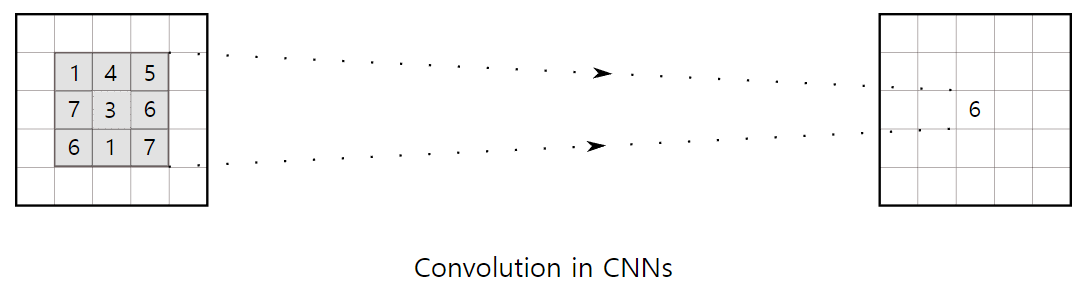

위 그림에서 CNN의 컨볼루션은 본질적으로 지역화(localized)되어 있다. 중심 픽셀에서 컨벌루션에 참여하는 이웃은 회색으로 강조 표시된다.

**[GNN]**

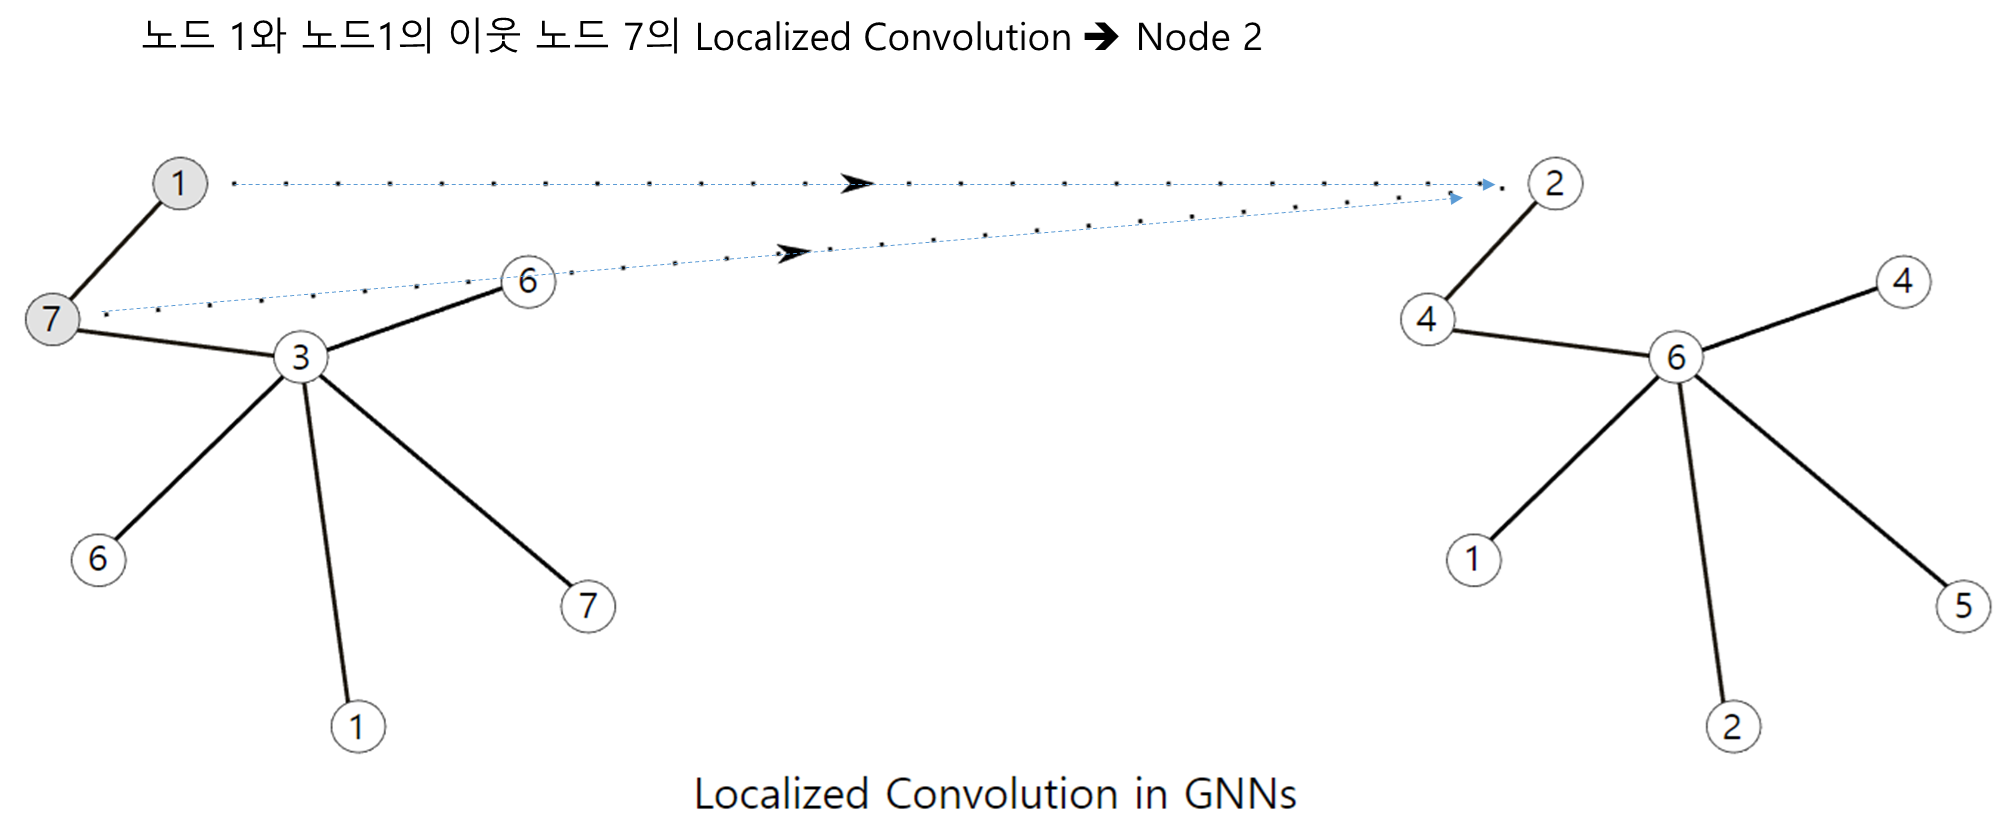

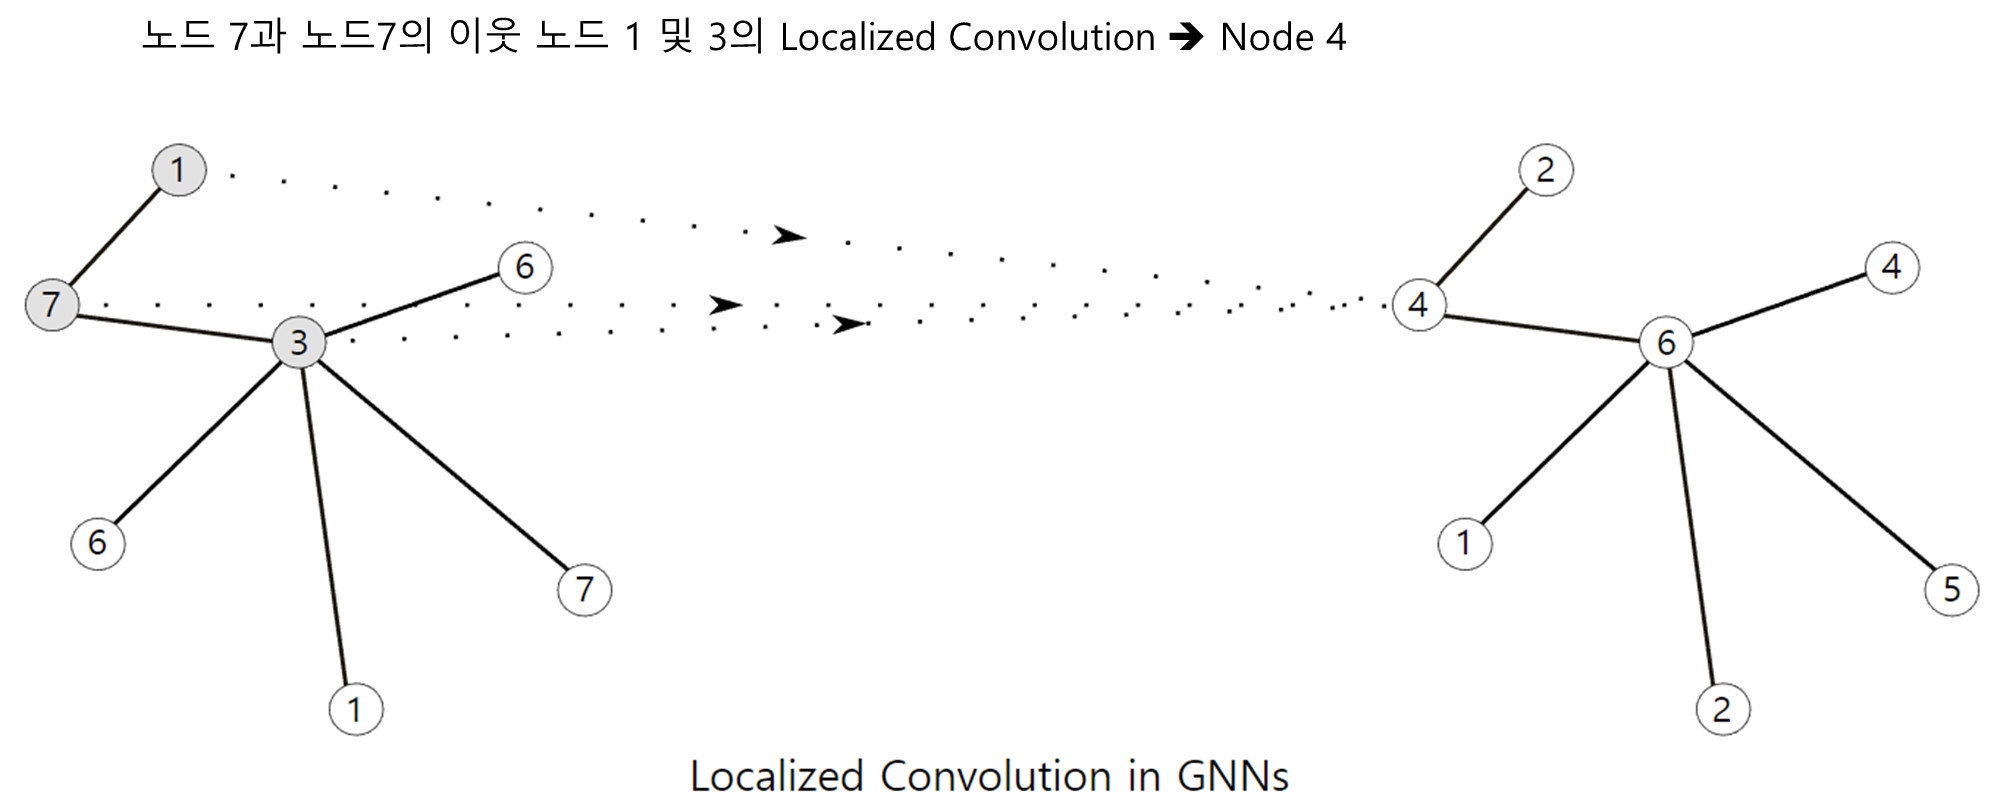

GNN 도 CNN을 모방한 지역화(localized)된 컨볼루션을 수행할 수 있다. 각 노드마다  이웃을 볼 수 있고, 이 이웃의 구조는 노드마다 바뀐다.

CNN이 이웃 픽셀에 대해 지역화된 필터를 계산하는 방식과 매우 유사하게 이웃 노드 에 대해 다항식 필터를 구성할 수 있다.

또한 노드 표현(임베딩)의 컴퓨팅을 위해 '글로벌' 그래프 수준 정보( ‘global’ graph-level information)를 사용할 수 도 있다.

# **4.Polynomial Filters on Graphs (그래프의 다항식 필터)**

##**[The Graph Laplacian 그래프 라플라시안]**

그래프 $G$가 주어질 때, $G$의 $n$ 노드의 임의 순서매기기를 고정하여, $G$의 $0-10$ 인접 행렬을 $A$로 표기하고 $G$의 차수행렬(대각행렬) $D$을 구성할 수 있다.


- $D_v = \sum_u A_{vu}$

- 노드 $v$ 의 차수는 $v$ 에서 발생하는 엣지의 갯수이다. 


- 여기서 $A_{vu}$ 는 행렬 $A$에서 $v$에 해당하는 행(row)과 $u$에 해당하는 열(column)의 항목(entry)을 나타낸다. 


그래프 라플라시안 $L$ 은 $L = D - A$ 로 정의되는 $n × n$ 정방행렬이다.

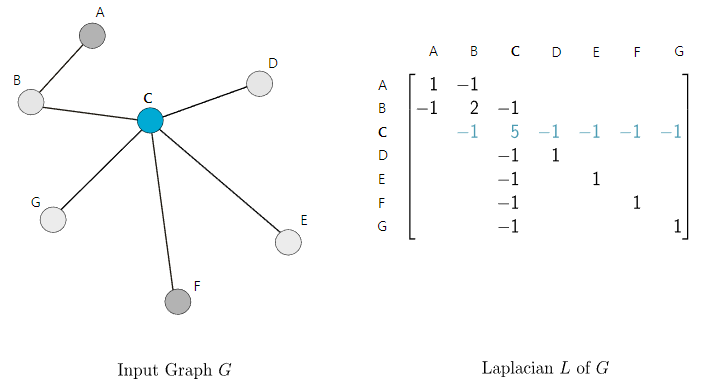

위 그래프는 무방향 그래프 $G$ 에 대한 라플라시안  $L$을 예시한 것으로, 노드 $C$ 에 해당하는 행이 강조 표시되어 있다. 위에서는 $L$ 내 0 값은 표시되지 않았다.

**라플라시안 $L$은 그래프 $G$의 구조에만 의존하고, 노드 특성에는 의존하지 않는다.**

그래프 Laplacian은 미적분에서 Laplacian 연산자의 이산 아날로그에서 그 이름을 따왔다.

인접 행렬 $A^3$ 과 정확히 동일한 정보를 인코딩하지만, 그래프 Laplacian은 그 자체로 많은 흥미로운 속성을 가지고 있다.

그래프 Laplacian에 대한 더 많은 학습을 원하면 아래 링크 자습서 참고

[A Short Tutorial on Graph Laplacians](https://csustan.csustan.edu/~tom/Clustering/GraphLaplacian-tutorial.pdf)


##**[Polynomials of the Laplacian 라플라시안 다항식]**

이제 그래프 Laplacian이 무엇인지 이해했으므로 다항식을 만들 수 있다.


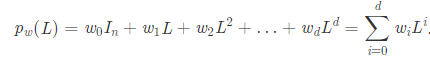

이 형식의 각 다항식은 계수의 벡터 $w = [w_0, \ldots, w_d]$ 로 번갈아 나타낼 수 있다. 이때 모든 $w, p_w(L)$ 는 $L$처럼 $n \times n$ 매트릭스이다.

**이러한 다항식은 CNN의 '필터'와 동등한 것으로 생각할 수 있으며 계수 $w$는 '필터'의 가중치로 생각할 수 있다.**

쉽게 설명하기 위해 노드가 1차원 특성을 갖는 경우에 초점을 맞추어보면, $v ∈ V$에 대한 $x_v$는 각각 실수이다.물론 동일한 아이디어는 $x_v$가 고차원의 벡터인 경우에도 유지된다.

이전에 선택한 노드 순서를 사용하여, $x ∈ {R}^n$ 벡터를 얻기 위해 모든 노드 특성 $x_v$을 쌓을 수 있다.

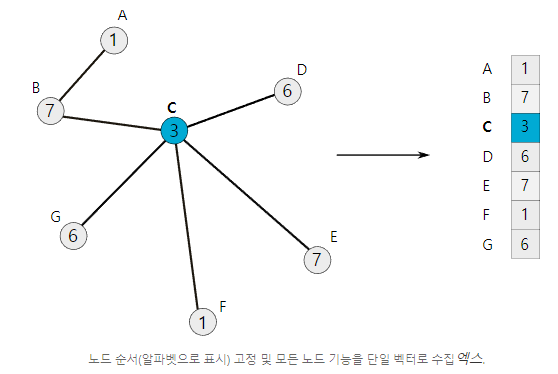

특성 벡터 $x$를 구성한 후, 다항식 필터 $p_w$와의 컨볼루션을 정의할 수 있다.

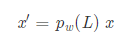

계수 $w$가 어떻게 컨벌루션에 영향을 미치는지를 되는지 이해하기 위해, $w_0 = 1$ 이고 다른 모든 계수가 0인 '가장 간단한' 다항식을 고려해본다.

이 경우엔 $x^{'}$가 단순하게 $x$가 된다.

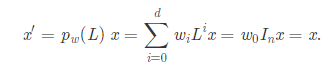

이제 차수를 높이고 대신에 $w_1 = 1$이고 다른 모든 계수는 0인 그래프를 고려하면, $x^{'}$는 $Lx$가 된다. 그래서

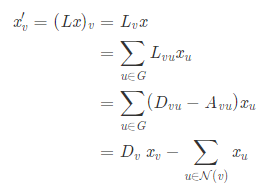

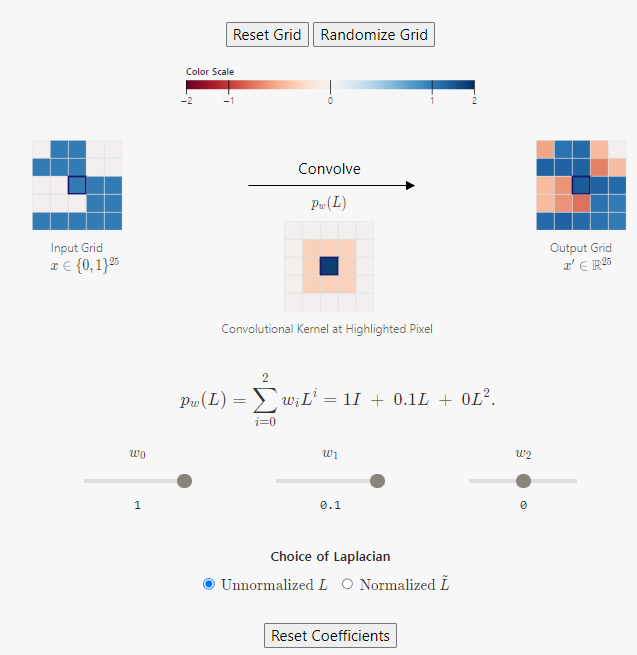

# **A Gentle Introduction to Graph Neural Networks**

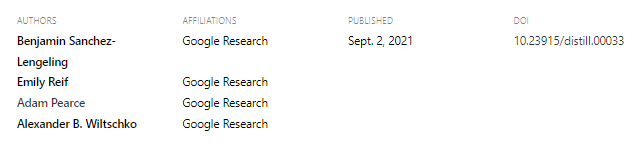

https://distill.pub/2021/gnn-intro/

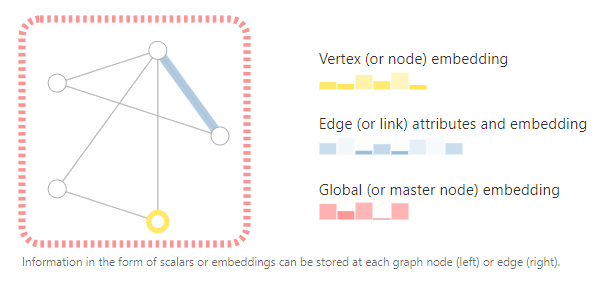

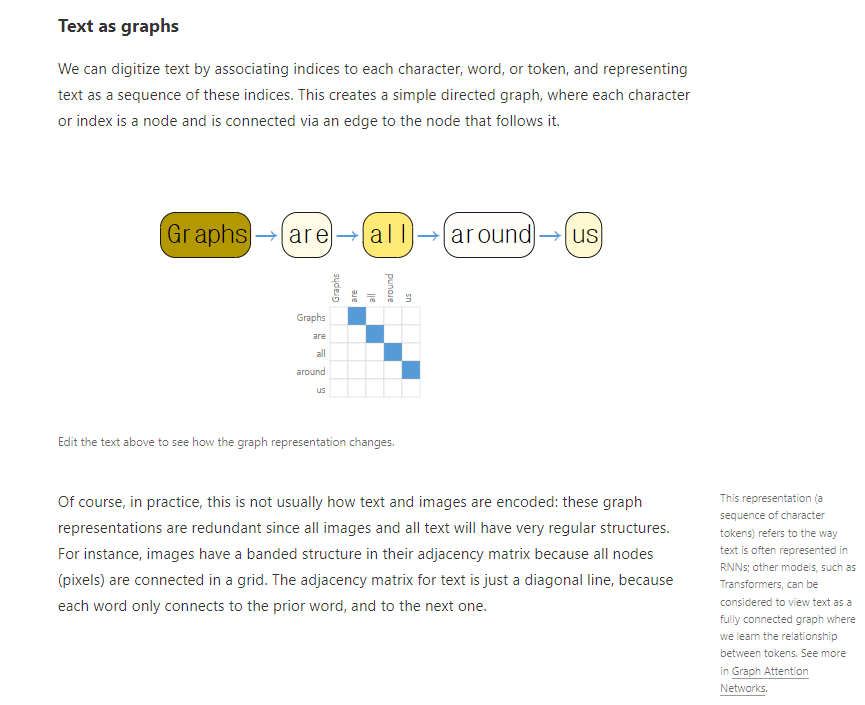

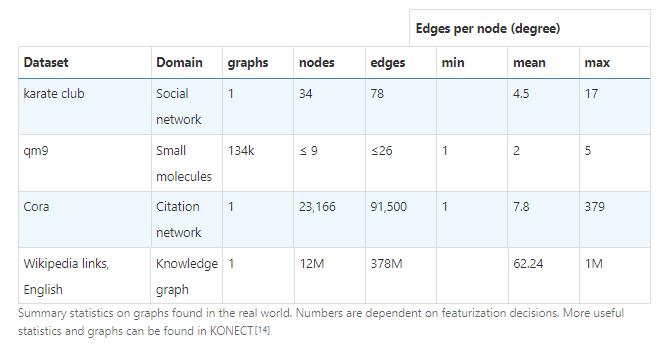

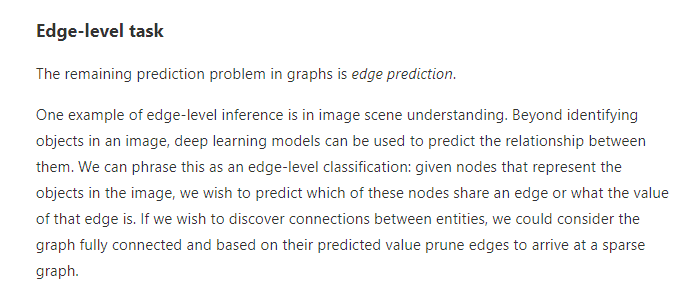

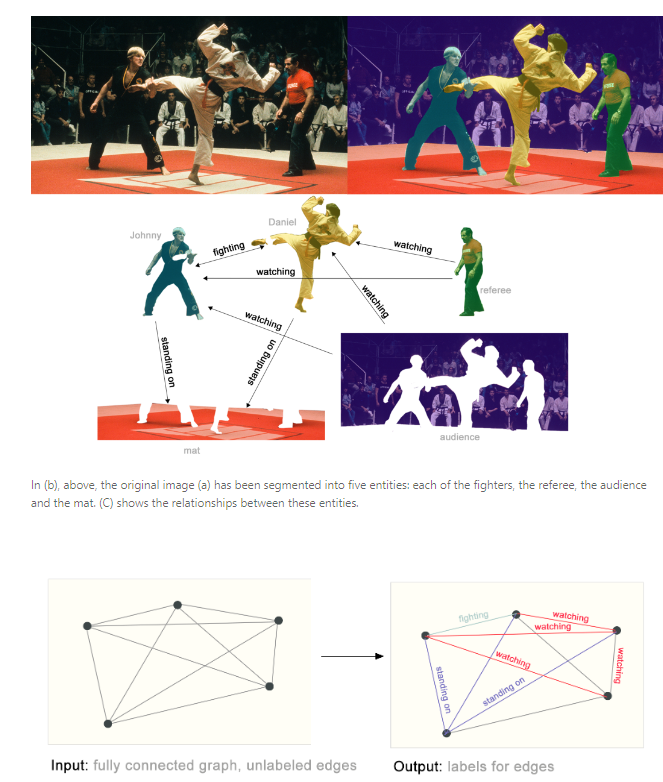

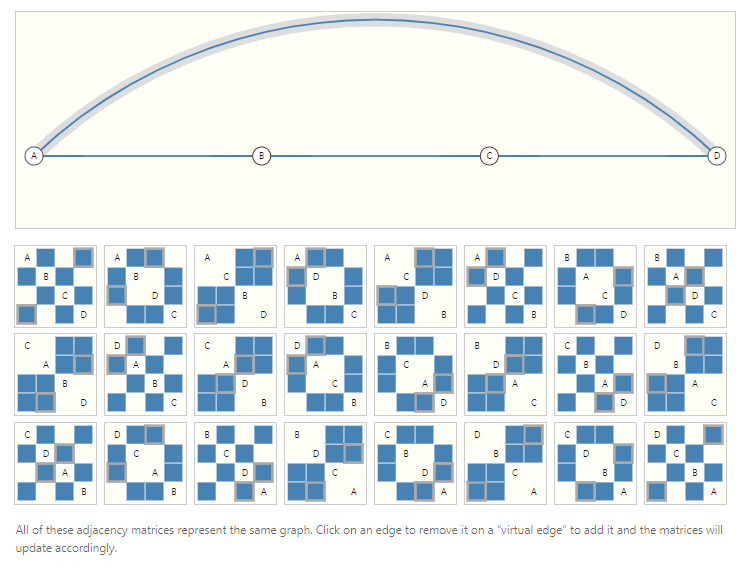

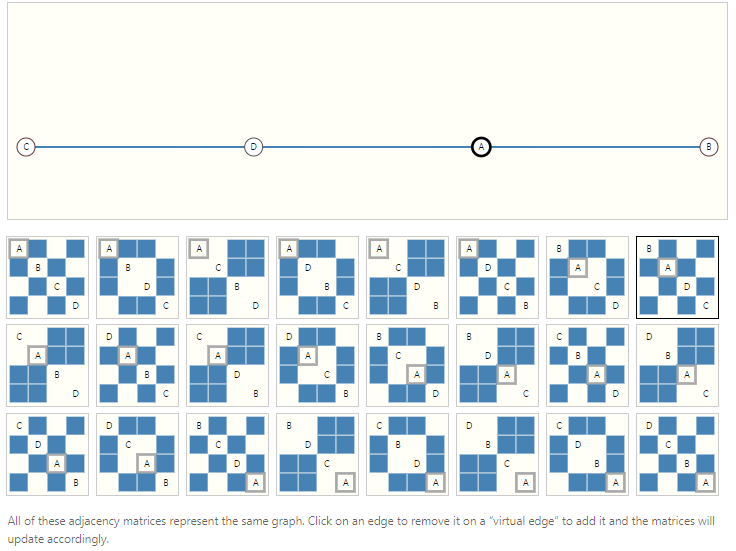

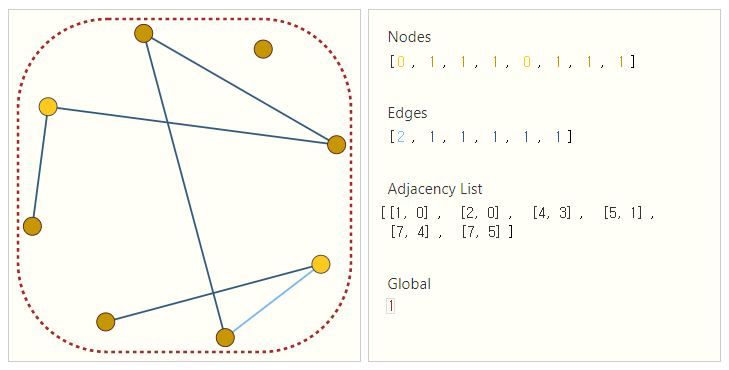

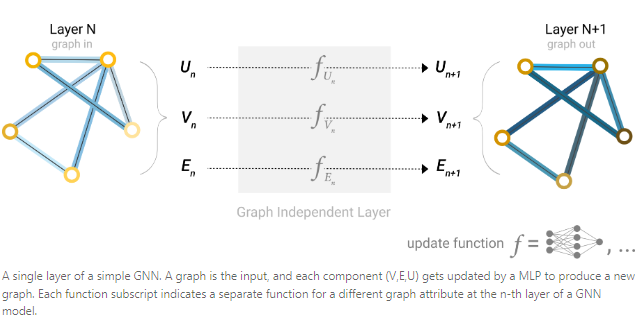

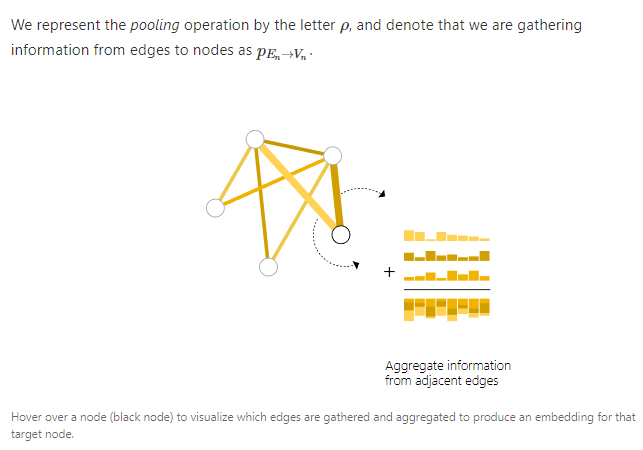